<a href="https://colab.research.google.com/github/JuanSpecht/ML2021/blob/main/TP3/ML_TP3_parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje de máquina: Trabajo práctico 3, parte 1

## Importo las bibliotecas necesarias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

## Funciones a utilizar

In [6]:
def generate_datasets(mean, var11, var22, var12, n, cat):
    cov_matrix = [[var11, var12], [var12, var22]] # matriz de covarianza

    rng = np.random.default_rng(2021)
    x1, x2 = rng.multivariate_normal(mean, cov_matrix, n).T

    df = pd.DataFrame({'X1': x1, 'X2': x2, 'Clase': cat})

    return df

# Función para graficar los datos en un scatter y marcar las regiones predichas como "A" y "B"
# referencia: http://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_iris_knn.html
def knn_scatter (df, neighbor_number, tsize):
    cmap_background = ListedColormap(['#d2d9ec', '#f9e0d2'])
    cmap_data = ListedColormap(['#4e65b2', '#e78047'])

    data = df.iloc[:,[0,1]]
    df.Clase = pd.Categorical(df.Clase)
    df['Code'] = df.Clase.cat.codes

    labels = df['Code'].values
    x_train, x_test, y_train, y_test = train_test_split(data, 
                                                        labels, 
                                                        test_size=tsize, 
                                                        random_state=1
                                                        )

    knn = neighbors.KNeighborsClassifier(n_neighbors=neighbor_number)
    knn.fit(x_train, y_train)

    x1_min, x1_max = df.X1.values.min() - .1, df.X1.values.max() + .1
    x2_min, x2_max = df.X2.values.min() - .1, df.X2.values.max() + .1
    
    x1x1, x2x2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                            np.linspace(x2_min, x2_max, 100))
    Z = knn.predict(np.c_[x1x1.ravel(), x2x2.ravel()])

    Z = Z.reshape(x1x1.shape)
    plt.figure(figsize=(5,5))
    plt.pcolormesh(x1x1, x2x2, Z, cmap=cmap_background)

    plt.scatter(df.X1, df.X2, c=df['Code'], 
                cmap=cmap_data, edgecolors=(1,1,1,0.8)
                )
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.axis('tight')

# Para graficar parámetros estadísticos en función de k
def plot_params(df):
    data = df.iloc[:,[0,1]]
    df.Clase = pd.Categorical(df.Clase)
    df['Code'] = df.Clase.cat.codes

    labels = df['Code'].values
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=1 )

    k_vec = np.arange(1,51,1)

    # Creo vectores vacíos para los elementos de la matriz de confusión
    tn = np.empty_like(k_vec)
    fp = np.empty_like(k_vec)
    fn = np.empty_like(k_vec)
    tp = np.empty_like(k_vec)

    # Calculo la matriz de confusión como función de k
    for k in k_vec:
        # Entreno el modelo para cada valor de k
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        # Obtengo la matriz de confusión
        y_true = y_test
        y_pred = knn.predict(x_test)
        tn[k-1], fp[k-1], fn[k-1], tp[k-1] = confusion_matrix(y_true, y_pred).ravel()

    # Defino los parámetros estadisticos
    p = np.sum(y_test) # Cantidad de positivos (clase B) en el grupo de testeo
    n = len(y_test) - p # Cantidad de negativos (clase A) en el grupo de testeo
    pp = np.sum(y_pred) # Predichos positivos (clase B)
    precision = tp/pp
    accuracy = (tp + tn) / (p + n)
    f_measure = 2*tp / (2*tp + fp + fn)
    jaccard = tp / (tp + fn + fp)
    bias = ((tp+fn)/(tn+fp))/((tp+fp)/(tn+fn))
    fdr = fp/(tp+fp)

    fig, ax = plt.subplots(6, sharex=True, figsize=(8,8))
    plt.minorticks_on()
    ax[0].plot(k_vec,precision)
    ax[1].plot(k_vec,accuracy)
    ax[2].plot(k_vec,f_measure)
    ax[3].plot(k_vec,jaccard)
    ax[4].plot(k_vec,bias)
    ax[5].plot(k_vec,fdr)

    ax[0].set_ylabel('Precisión')
    ax[1].set_ylabel('Exactitud')
    ax[2].set_ylabel('F-measure')
    ax[3].set_ylabel('Ind. de Jaccard')
    ax[4].set_ylabel('Sesgo')
    ax[5].set_ylabel('FDR')
    plt.xlabel("k")
    
    
    plt.axis('tight')

# Para hacer un scatter interactivo con k y N como variables
def interactive_scatter(df):
    widgets.interact(knn_scatter,
                     df = widgets.fixed(df),
                     neighbor_number = widgets.IntSlider(
                         value=10,
                         min=1,
                         max=50,
                         step=1,
                         description='K:',
                         orientation='horizontal'
                         ),
                     tsize = widgets.FloatSlider(
                         value=0.5,
                         min=0.1,
                         max=0.5,
                         step=0.05,
                         description='N:',
                         orientation='horizontal'
                         )
                     )

## Genero el dataset y lo visualizo

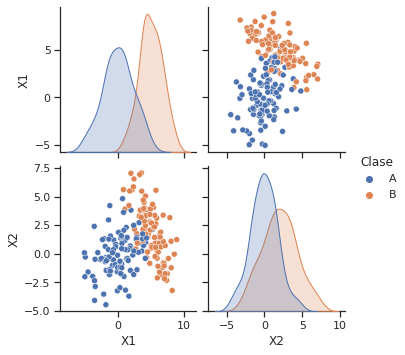

In [7]:
# Genero los datasets "A" y "B"
df_a = generate_datasets([0, 0], 6, 3, 1.5, 100, 'A')
df_b = generate_datasets([5, 2], 3, 6, -3, 100, 'B')

# Concateno y randomizo los datasets
df_ab = pd.concat([df_a, df_b])
df_shuffled = df_ab.sample(frac=1).reset_index(drop=True)

sns.set_theme(style="ticks")
sns.pairplot(df_shuffled, hue="Clase")

## Gráfico interactivo con K (número de vecinos) y N (cantidad de datos para testeo) como variables

In [8]:
interactive_scatter(df_shuffled)

interactive(children=(IntSlider(value=10, description='K:', max=50, min=1), FloatSlider(value=0.5, description…

* Utilizando k = 10 y un split de 50% / 50% entre entrenamiento y testeo, hay muchos datos de la clase "A" identificados como "B". Esto puede deberse a que la varianza del grupo de datos "B" es menor que la del grupo "A" en la dirección de la recta que une ambos centroides. Por este motivo, los datos "A" que están dentro de la nube "B" tienen más vecinos "B" que "A".
* Si se incrementa el valor de k se ve que crece el número de datos "A" identificados como "B" (en el gráfico se retrae la mancha "A" en favor de la "B"). Lo contrario sucede si disminuímos el valor de k.

## Obtengo la matriz de confusión y calculo diferentes parámetros estadísticos en función de k para decidir el valor de k (con un split de 50% / 50%)

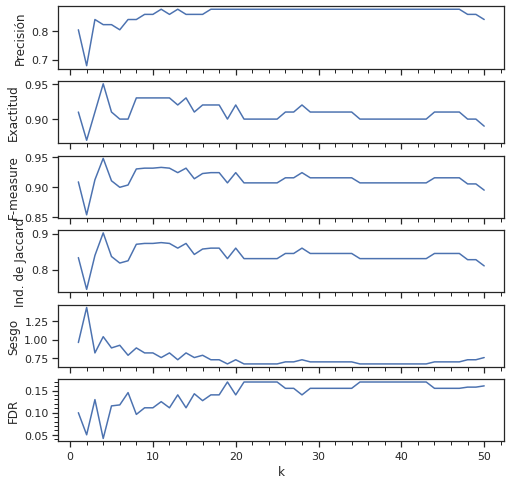

In [15]:
plot_params(df_shuffled)

* Se ve que ninguno de los parámetros (excepto el sesgo) varía significativamente para el rango de k mostrado.
* El sesgo y el FDR son los parámetros que varían más marcadamente con k.
* La exactitud, f-measure e índice de Jaccard tienen su máximo en k = 4, donde el FDR tiene uno de los valores más bajos, con lo cual k = 4 puede ser una buena elección. 

Observación: Estos gráficos cambian con cada corrida ya que la función que separa los datos para entrenamiento y testeo lo hace de manera aleatoria, con lo que cada corrida resulta en un nuevo valor o valores de k óptimos.

## Ahora pruebo con datasets cuyos centroides son más cercanos pero sin modificar las matrices de covarianza

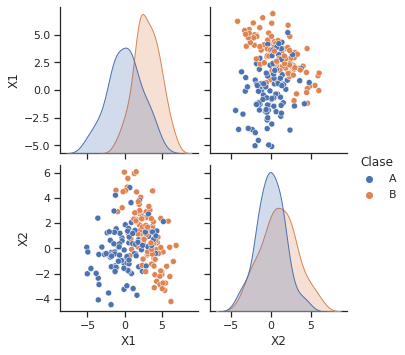

In [10]:
# Genero los datasets "A" y "B"
df_a_2 = generate_datasets([0, 0], 6, 3, 1.5, 100, 'A')
df_b_2 = generate_datasets([3, 1], 3, 6, -3, 100, 'B')

# Concateno y randomizo los datasets
df_ab_2 = pd.concat([df_a_2, df_b_2])
df_shuffled_2 = df_ab_2.sample(frac=1).reset_index(drop=True)

sns.set_theme(style="ticks")
sns.pairplot(df_shuffled_2, hue="Clase")

* En este caso los dos conjuntos se solapan significativemnte, por lo que se espera que el clasificador no sea tan bueno como con el dataset anterior

In [11]:
interactive_scatter(df_shuffled_2)

interactive(children=(IntSlider(value=10, description='K:', max=50, min=1), FloatSlider(value=0.5, description…

* Se puede ver que al acercar los centroides el clasificador empeora su calidad. Hay una mayor cantidad de datos del grupo "A" identificados como "B" y viceversa, cualquiera sea el valor de k.

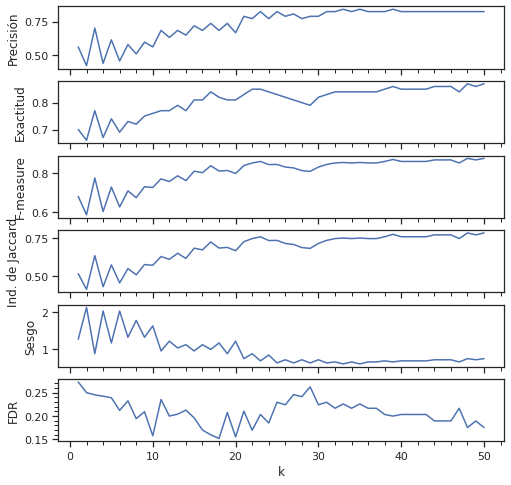

In [12]:
plot_params(df_shuffled_2)

* Observando cómo se comportan los parámetros estadísticos al acercar los centroides se ve que los valores de todos los parámetros son menos favorables, dado que el clasificador no es capaz de asignar adecuadamente la categoría a los datos.
* En este caso se ve que para un valor de k alrededor de 22 se obtienen los valores más favorables de los distintos parámetros. 


## Ahora modifico las matrices de covarianza si afectar la distancia entre centroides

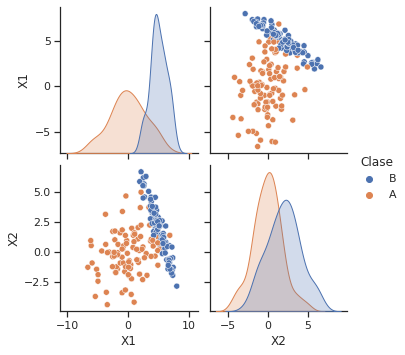

In [12]:
# Genero los datasets "A" y "B"
df_a_3 = generate_datasets([0, 0], 10, 3, 1.5, 100, 'A')
df_b_3 = generate_datasets([5, 2], 2, 5, -3, 100, 'B')

# Concateno y randomizo los datasets
df_ab_3 = pd.concat([df_a_3, df_b_3])
df_shuffled_3 = df_ab_3.sample(frac=1).reset_index(drop=True)

sns.set_theme(style="ticks")
sns.pairplot(df_shuffled_3, hue="Clase")

* Ahora la distribución del grupo "B" tiene una varianza mucho mayor en una dirección, con lo cual hay una mayor correlación entre las variables X1 y X2 para este grupo.

In [17]:
interactive_scatter(df_shuffled_3)

interactive(children=(IntSlider(value=10, description='K:', max=50, min=1), FloatSlider(value=0.5, description…

* Se ve que sin importar el valor de k, en este caso el clasificdor no genera falsos "A", y cuanto mayor es el valor de k más falsos "B" aparecen (la frontera se acerca al centroide de los "B").

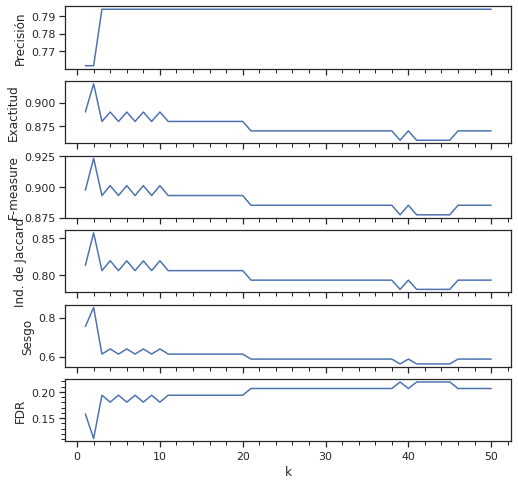

In [18]:
plot_params(df_shuffled_3)

* En el gráfico de arriba se puede comprobar que prácticamente para cualquier valor de k, la precisión (tp/pp) no varía ya que no cambia la cantidad de datos que el clasificador asigna correctamente a la categoría "B" (tp)